In [1]:
from lightgbm import LGBMClassifier

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

from typing import List, Any, Tuple
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
scaler = MinMaxScaler(feature_range=(0,1))

In [3]:
# Filter outliers by "entire"
# Ref: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
print("Filtering outliers...")
df_base = pd.concat([X_model, Y_model], axis=1)
df_processed = pd.DataFrame(data=df_base, columns=['business'])
df_processed['cEntire'] = df_base.filter(regex="c" + r"2022[0-9]*", axis=1).fillna(0).sum(axis=1)
df_processed['tEntire'] = df_base.filter(regex="t" + r"2022[0-9]*", axis=1).fillna(0).sum(axis=1)
df_processed['sEntire'] = df_base.filter(regex="s" + r"2022[0-9]*", axis=1).fillna(0).sum(axis=1)

# outliers = []

# def collect_outliers(business: int, key: str):
#     df_target = df_processed[df_processed['business'] == business]
#     q1, q3 = df_target[key].quantile([0.25, 0.75])
#     iqr = q3 - q1
#     cutoff = iqr * 2.0
#     lower, upper = q1 - cutoff, q3 + cutoff
#     _outliers = df_target[(df_target[key] < lower) | (df_target[key] > upper)].index.tolist()
#     print(len(_outliers))
#     outliers.extend(_outliers)

# collect_outliers(0, 'cEntire')
# collect_outliers(1, 'cEntire')
# collect_outliers(0, 'tEntire')
# collect_outliers(1, 'tEntire')
# collect_outliers(0, 'sEntire')
# collect_outliers(1, 'sEntire')

# outliers = list(set(outliers))

# Filter outliers from df
# def filter_outliers_from_df(df: pd.DataFrame, outliers):
#     return df.drop(outliers)

# X_model = filter_outliers_from_df(X_model, outliers)
# Y_model = filter_outliers_from_df(Y_model, outliers)

# Get columns of "c" prefix of last 5 days of month
last_5_days = [
    *[f"c202201{i + 27}" for i in range(5)],
    *[f"c202202{i + 24}" for i in range(5)],
    *[f"c202203{i + 27}" for i in range(5)],
    *[f"c202204{i + 26}" for i in range(5)],
    *[f"c202205{i + 27}" for i in range(5)],
    *[f"c202206{i + 26}" for i in range(5)],
    *[f"c202207{i + 27}" for i in range(5)],
]
last_5_days_sum = X_model.filter(last_5_days, axis=1).fillna(0).sum(axis=1)
# print(last_5_days_sum.head())
last_5_days_sum = last_5_days_sum.sort_values(ascending=False)
# print(last_5_days_sum.index)

# Define scaler
# print("Defining scaler...")
# scaler = MinMaxScaler(feature_range=(0,1))

# Define preprocessors
print("Defining preprocessors...")
def column(colnames: List[str]):
    def _column(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [colname, X[colname].values] for colname in colnames
        ]
    return _column

def rangesum(
    name:str, 
    regex: str, 
    prefixes: str, 
    dist: np.ndarray
):
    def _rangesum(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [
                prefix + name, 
                X.filter(regex=(prefix + regex), axis=1).values.dot(dist)
            ] for prefix in prefixes
        ]
    return _rangesum

def rangesum_from_list(
    name: str, 
    namelist: List[str], 
    prefix: str,
    dist: np.ndarray,    
):
    def _rangesum_from_list(X: pd.DataFrame):
        X = X.fillna(0)
        return [
            [
                prefix + name, 
                X[namelist].values.dot(dist)
            ]
        ]
    return _rangesum_from_list

def _fillna(X: np.ndarray) -> np.ndarray:
    return np.nan_to_num(X, copy=True, nan=0)

def array_divide(
    numerator: List[Tuple[str, np.ndarray]], 
    denominator: List[Tuple[str, np.ndarray]]
) -> List[Any]:
    assert len(numerator) == len(denominator)
    return [
        [
            "r" + numerator_colname, 
            _fillna(np.divide(numerator_col, denominator_col))
        ] for [numerator_colname, numerator_col], [_, denominator_col] in zip(numerator, denominator)
    ]

def one_hot_encode(column: str) -> pd.DataFrame:
    def _one_hot_encode(X: pd.DataFrame):
        X = X.fillna(0)
        df_dummies = pd.get_dummies(X[column], prefix=column)
        return [
            [colname, df_dummies[colname].values] for colname in df_dummies.columns
        ]
    return _one_hot_encode

def preprocess(X: pd.DataFrame, processors: List[Any]) -> pd.DataFrame:
    X_new = pd.DataFrame()

    for processor in processors:
        for colname, col in processor if type(processor) == type([]) else processor(X):
            X_new[colname] = col

    X_new = X_new.fillna(0)

#     X_new = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

    return X_new

def equal_dist(length: int) -> np.ndarray:
    return np.ones(length)

def linear_dist(length: int) -> np.ndarray:
    return np.arange(start=0, stop=1, step=1/length)

def triangle_dist(length: int) -> np.ndarray:
    return np.concatenate(
        [
            np.arange(start=0, stop=1, step=1/length),
            np.arange(start=1, stop=0, step=-1/length)
        ]
    )

Filtering outliers...
Defining preprocessors...


In [4]:
# Get columns of "c" prefix of last 5 days of month
last_5_days = [
    *[f"c202201{i + 27}" for i in range(5)],
    *[f"c202202{i + 24}" for i in range(5)],
    *[f"c202203{i + 27}" for i in range(5)],
    *[f"c202204{i + 26}" for i in range(5)],
    *[f"c202205{i + 27}" for i in range(5)],
    *[f"c202206{i + 26}" for i in range(5)],
    *[f"c202207{i + 27}" for i in range(5)],
]
last_5_days_sum = X_model.filter(last_5_days, axis=1).fillna(0).sum(axis=1)
last5_code = np.array(last_5_days_sum)
last_5_days_sum_list =[]
last_5_days_sum_list.append(['last_5_days_sum',last5_code])

In [5]:
print("Data preprocessing...")
dist_GIT = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_model)
dist_VAT = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_model)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_model)

age_code = np.array(X_model['age_code'])
gender_code = np.array(X_model['gender'])
region_code = np.array(X_model['region_code'])
cat_Featrues = []
cat_Featrues.append(['gender',age_code])
cat_Featrues.append(['age_code',age_code])
cat_Featrues.append(['region_code',region_code])

X_processed = preprocess(
    X_model, 
    [
        cat_Featrues,
        dist_GIT,
        dist_VAT,
        entire,
        last_5_days_sum_list
        # array_divide(dist_GIT, entire), # rel_GIT
        # array_divide(dist_VAT, entire[1:]), # rel_VAT
    ]
)
X_processed.head(3)

Data preprocessing...


,gender,age_code,region_code,cGIT,tGIT,sGIT,tVAT,sVAT,cEntire,tEntire,sEntire,last_5_days_sum
0,13,13,7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,93.0,0.0
1,5,5,1,2.0,0.0,17.0,0.0,185.0,39.0,0.0,790.0,4.0
2,6,6,2,6.0,3.0,2253.0,0.0,1712.0,26.0,3.0,5119.0,0.0


In [9]:
Mix = pd.concat([X_processed,Y_model],axis=1)

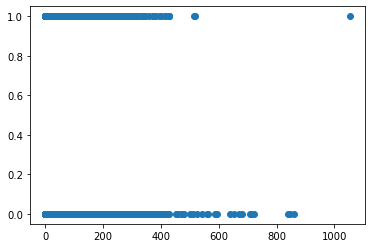

In [13]:
plt.scatter(Mix['last_5_days_sum'],Mix['business'])
plt.show()

In [21]:
a = Mix[(Mix['last_5_days_sum']>1000) & (Mix['business']==1)].index

In [22]:
Mix = Mix.drop(a)

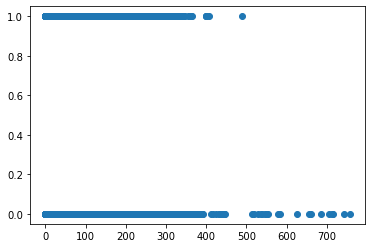

In [24]:
plt.scatter(Mix['cGIT'],Mix['business'])
plt.show()

In [25]:
b = Mix[(Mix['cGIT']>450) & (Mix['business']==1)].index
Mix = Mix.drop(b)

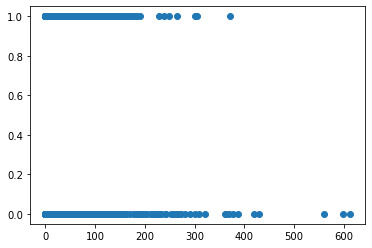

In [27]:
plt.scatter(Mix['tGIT'],Mix['business'])
plt.show()

In [28]:
c= Mix[(Mix['tGIT']>500) & (Mix['business']==0)].index
Mix = Mix.drop(c)

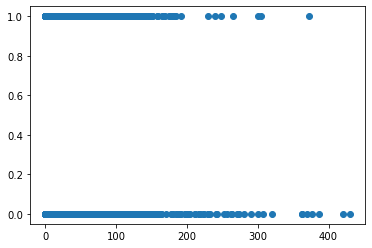

In [29]:
plt.scatter(Mix['tGIT'],Mix['business'])
plt.show()

In [30]:
d= Mix[(Mix['tGIT']>350) & (Mix['business']==1)].index
Mix = Mix.drop(d)

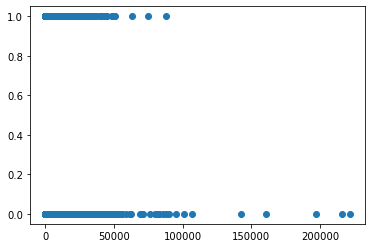

In [32]:
plt.scatter(Mix['sGIT'],Mix['business'])
plt.show()

In [33]:
e= Mix[(Mix['sGIT']>130000) & (Mix['business']==0)].index
Mix = Mix.drop(e)

In [ ]:
# tVAT	sVAT	cEntire	tEntire	sEntire

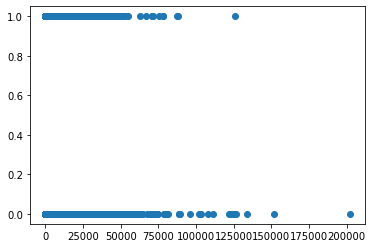

In [38]:
plt.scatter(Mix['sVAT'],Mix['business'])
plt.show()

In [39]:
f= Mix[(Mix['sVAT']>200000) & (Mix['business']==0)].index
Mix = Mix.drop(f)

In [41]:
g= Mix[(Mix['sVAT']>120000) & (Mix['business']==1)].index
Mix = Mix.drop(g)

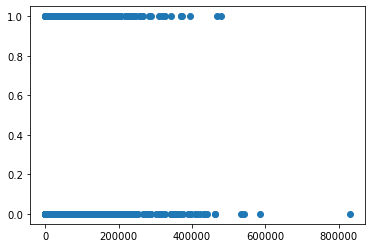

In [44]:
plt.scatter(Mix['sEntire'],Mix['business'])
plt.show()

In [45]:
h = Mix[(Mix['sEntire']>800000) & (Mix['business']==0)].index
Mix = Mix.drop(h)

In [47]:
Mix.shape # removed 14 outliers

(799986, 13)

In [68]:
X_processed = Mix.loc[:,'gender':'last_5_days_sum']
Y_model = Mix['business']

In [69]:
print("Preparing for hyperparameter tuning...")
def _construct_and_cross_validate(**kwargs):

    lgbm = LGBMClassifier(
        task = "train",
        objective = "binary", #cross-entropy
        metric = "auc",
        tree_learner = "data",
        random_state=100,
        categorical_feature = [0,1,2],
        class_weight={0: 1, 1: 14.291397},
        n_estimators=kwargs['n_estimators'],
        # to deal with overfitting, very important param
        max_depth=kwargs['max_depth'],
        learning_rate=kwargs['learning_rate'],
        num_leaves=kwargs['num_leaves'],
        min_data_in_leaf=kwargs['min_data_in_leaf'],
        #if max_bin becomes small, the accuracy goes up
        max_bin=kwargs['max_bin'],
        lambda_l1=kwargs['lambda_l1'],
        lambda_l2=kwargs['lambda_l2'],
        # to deal with overfitting
        min_child_weight=kwargs['min_child_weight'],
        #for bagging imbalanced
        bagging_fraction=kwargs['bagging_fraction'],
        pos_bagging_fraction=kwargs['pos_bagging_fraction'],
        neg_bagging_fraction=kwargs['neg_bagging_fraction'],
    )
    #cross validation K=5
    scores = cross_val_score(
        lgbm, 
        X_processed, 
        Y_model, 
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        scoring="roc_auc"
    )
    return scores

# Task: Hyperparameter tuning with Optuna
def objective(trial: Trial):
    # Construct a DecisionTreeClassifier object
    scores = _construct_and_cross_validate(
        n_estimators=trial.suggest_int('n_estimators',100,500),
        # to deal with overfitting, very important param
        max_depth = trial.suggest_int('max_depth',10,20),
        learning_rate = trial.suggest_float('learning_rate',0.02,0.1),
        num_leaves = trial.suggest_int('num_leaves',500,1000),
        min_data_in_leaf = trial.suggest_int('min_data_in_leaf',100,1000),
        #if max_bin becomes small, the accuracy goes up
        max_bin = trial.suggest_int('max_bin',255,350),
        lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-3, 10.0),
        lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-3, 10.0),
        # to deal with overfitting
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        #for bagging imbalanced
        bagging_fraction = trial.suggest_float('bagging_fraction', 0,1),
        pos_bagging_fraction = trial.suggest_float('pos_bagging_fraction', 0,1),
        neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0,1),
    )

    return scores.mean()

print("Hyperparameter tuning started...")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
# Optimize 300 times
study.optimize(objective, n_trials=300)

# Print the best parameters
print("Best params")
print(study.best_params)

Preparing for hyperparameter tuning...
Hyperparameter tuning started...
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] lambda_l1 is set=7.843173612137413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843173612137413
[LightGBM] [Warning] bagging_fraction is set=0.022948082497939448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.022948082497939448
[LightGBM] [Warning] lambda_l2 is set=0.6593129362720613, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6593129362720613
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] lambda_l1 is set=7.843173612137413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.843173612137413
[LightGBM] [Warning] bagging_fraction is set=0.022948082497939448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0

[LightGBM] [Warning] min_data_in_leaf is set=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] lambda_l1 is set=3.292586379759932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292586379759932
[LightGBM] [Warning] bagging_fraction is set=0.0030223516811503925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0030223516811503925
[LightGBM] [Warning] lambda_l2 is set=6.373511544722731, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.373511544722731
[LightGBM] [Warning] min_data_in_leaf is set=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] lambda_l1 is set=3.292586379759932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.292586379759932
[LightGBM] [Warning] bagging_fraction is set=0.0030223516811503925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.0030223516811503925
[LightGBM] [Warning] lambda_l2 is set=6.373511544722

[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.059689143983

[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527
[LightGBM] [Warning] lambda_l1 is set=2.1104873859106115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1104873859106115
[LightGBM] [Warning] bagging_fraction is set=0.2855998595782262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2855998595782262
[LightGBM] [Warning] lambda_l2 is set=0.0972775381054041, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0972775381054041
[LightGBM] [Warning] min_data_in_leaf is set=527, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=527
[LightGBM] [Warning] lambda_l1 is set=2.1104873859106115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1104873859106115
[LightGBM] [Warning] bagging_fraction is set=0.2855998595782262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2855998595782262
[LightGBM] [Warning] lambda_l2 is set=0.0972775381054041, 

In [70]:
print("Finalizing model...")
scores = _construct_and_cross_validate(
    n_estimators=study.best_params['n_estimators'],
    # to deal with overfitting, very important param
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    num_leaves=study.best_params['num_leaves'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    #if max_bin becomes small, the accuracy goes up
    max_bin=study.best_params['max_bin'],
    lambda_l1=study.best_params['lambda_l1'],
    lambda_l2=study.best_params['lambda_l2'],
    # to deal with overfitting
    min_child_weight=study.best_params['min_child_weight'],
    #for bagging imbalanced
    bagging_fraction=study.best_params['bagging_fraction'],
    pos_bagging_fraction=study.best_params['pos_bagging_fraction'],
    neg_bagging_fraction=study.best_params['neg_bagging_fraction'],
)

print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))


Finalizing model...
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 i

In [71]:
optimized_LGBM = LGBMClassifier(
    task = "predict",
    objective = "binary",
    metric = "auc",
    tree_learner = "data",
    categorical_feature = [0,1,2],
    class_weight={0: 1, 1: 14.291397},
    n_estimators=study.best_params['n_estimators'],
    
    # to deal with overfitting, very important param
    max_depth=study.best_params['max_depth'],
    learning_rate=study.best_params['learning_rate'],
    num_leaves=study.best_params['num_leaves'],
    min_data_in_leaf=study.best_params['min_data_in_leaf'],
    
    #if max_bin becomes small, the accuracy goes up
    max_bin=study.best_params['max_bin'],
    lambda_l1=study.best_params['lambda_l1'],
    lambda_l2=study.best_params['lambda_l2'],
    
    # to deal with overfitting
    min_child_weight=study.best_params['min_child_weight'],
    #for bagging imbalanced
    bagging_fraction=study.best_params['bagging_fraction'],
    pos_bagging_fraction=study.best_params['pos_bagging_fraction'],
    neg_bagging_fraction=study.best_params['neg_bagging_fraction'],
)

In [73]:
# print("Executing...")
# Y_exam = np.zeros(X_exam_processed.shape[0])
# k = 5
# kf = StratifiedKFold(n_splits=k)
# for tr_index, val_index in kf.split(X_processed,Y_model):
#     X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
#     X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]
    
#     optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc')
#     proba = optimized_LGBM.predict_proba(X_exam_processed)[:,1]
#     Y_exam = Y_exam + proba
# Y_exam = Y_exam/k
# thresholds = np.array([0.4,0.5,0.6,0.7,0.8,0.9])
# # the ratio of high prob with different thresholds
# for num in thresholds: 
#     filtered = Y_exam[np.where(Y_exam>=num)]
#     print("the number of probability more than %.2f is %d:" %(num,len(filtered)))
#     print("the ratio of probability more than %.2f is : %.4f"%(num, float(len(filtered))/len(Y_exam)))
#     print('---------------------------------------------------\n')
# # res = pd.DataFrame({'business prob':Y_exam})
# # res.to_csv("./part1.csv")


In [74]:
from sklearn.metrics import accuracy_score
# Y_exam = np.zeros(X_exam_processed.shape[0])

accuracy_Arr = np.array([])
popup_Arr = np.array([])
survey_Arr = np.array([])

k = 5
kf = StratifiedKFold(n_splits=k)
thresholds = [0.4,0.48,0.5,0.53,0.65,0.7,0.75]
for th in thresholds:
    popup_P = 0
    survey_P = 0
    accuracy = 0
    for tr_index, val_index in kf.split(X_processed,Y_model):
        X_tr,Y_tr = X_processed.iloc[tr_index],Y_model.iloc[tr_index]
        X_val, Y_val = X_processed.iloc[val_index],Y_model.iloc[val_index]

        optimized_LGBM.fit(X_tr,Y_tr,eval_metric='auc')
        # Generate the columns
        proba = optimized_LGBM.predict_proba(X_val)[:,1]
        pred = pd.DataFrame({'business prob_pred':proba})
        popup = pd.DataFrame({'popup':np.zeros(X_val.shape[0])})
        survey = pd.DataFrame({'survey':np.zeros(X_val.shape[0])})
#         login = pd.DataFrame({'login':np.zeros(X_val.shape[0])})
        
        # Merge
        res = pd.concat([pred,popup],axis=1)
        res = pd.concat([res,survey],axis=1)
#         res = pd.concat([res,login],axis=1)
        
        # If predicted proba is more than th, put his popup as 1
        res.loc[res['business prob_pred'] >= th, 'popup'] = 1
        res.loc[ (res['business prob_pred'] >= th)&(X_val['last_5_days_sum']>0) , 'survey'] = 1
        
        accuracy += accuracy_score(Y_val, res['popup'])
        res = pd.concat([res,Y_val.reset_index(drop=True)],axis=1) # Merge res with Y_val
        popup_P += res.loc[res['popup']==1,'business'].sum()*(500000*0.01) - res['popup'].sum()*400
        survey_P += res.loc[res['survey']==1,'business'].sum()*(500000*0.036) - res['survey'].sum()*5000*0.18
        
    accuracy_Arr = np.append(accuracy_Arr,accuracy/k)
    popup_Arr = np.append(popup_Arr,popup_P/k)
    survey_Arr = np.append(survey_Arr,survey_P/k)
    

#     print('---------------------------------')
#     print(accuracy_score(Y_val, res['popup']))
#     print('---------------------------------')
#     print('net profit:')
#     profit = res.loc[res['popup']==1,'business'].sum()*(500000*0.01) - res['popup'].sum()*400
#     print(profit)
#     print('---------------------------------')


[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.059689143983

[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.059689143983

[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078
[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.059689143983

In [75]:
df = pd.DataFrame({'threshold':thresholds, 'avg_Accuracy':accuracy_Arr, 'avg_Popup_Profit':popup_Arr, 'avg_Survey_Porfit':survey_Arr})
df.set_index('threshold')
print(df)

   threshold  avg_Accuracy  avg_Popup_Profit  avg_Survey_Porfit
0       0.40      0.686820        25849520.0         20174400.0
1       0.48      0.716723        26507480.0         20156040.0
2       0.50      0.724748        26610320.0         20131200.0
3       0.53      0.736827        26692880.0         19968660.0
4       0.65      0.793565        25307600.0         18174960.0
5       0.70      0.831893        22974240.0         16076520.0
6       0.75      0.879454        18264040.0         12313620.0


In [76]:
X_exam = pd.read_csv('X_exam.csv')
print("Data preprocessing...")
dist_GIT_exam = rangesum(
    'GIT', 
    r"202205[0-9]{2}", 
    "cts", 
    equal_dist(31)
)(X_exam)
dist_VAT_exam = rangesum(
    'VAT', 
    r"20220[17](?:[01][0-9]|2[0-5])", 
    "ts", 
    np.concatenate((equal_dist(25), equal_dist(25)))
)(X_exam)
entire_days = 31 + 29 + 31 + 30 + 31 + 30 + 31 + 25
entire_exam = rangesum(
    'Entire', 
    r"2022[0-9]{4}", 
    "cts", 
    equal_dist(entire_days)
)(X_exam)

age_code_exam = np.array(X_exam['age_code'])
gender_code_exam = np.array(X_exam['gender'])
region_code_exam = np.array(X_exam['region_code'])
cat_Featrues_exam = []
cat_Featrues_exam.append(['gender',age_code_exam])
cat_Featrues_exam.append(['age_code',age_code_exam])
cat_Featrues_exam.append(['region_code',region_code_exam])

# Get columns of "c" prefix of last 5 days of month
last_5_days = [
    *[f"c202201{i + 27}" for i in range(5)],
    *[f"c202202{i + 24}" for i in range(5)],
    *[f"c202203{i + 27}" for i in range(5)],
    *[f"c202204{i + 26}" for i in range(5)],
    *[f"c202205{i + 27}" for i in range(5)],
    *[f"c202206{i + 26}" for i in range(5)],
    *[f"c202207{i + 27}" for i in range(5)],
]
last_5_days_sum_exam = X_exam.filter(last_5_days, axis=1).fillna(0).sum(axis=1)
last_5_days_sum_exam = X_exam.filter(last_5_days, axis=1).fillna(0).sum(axis=1)
last5_code_exam = np.array(last_5_days_sum_exam)
last_5_days_sum_list_exam =[]
last_5_days_sum_list_exam.append(['last_5_days_sum',last5_code_exam])

X_exam_processed = preprocess(
    X_exam, 
    [
        cat_Featrues_exam,
        dist_GIT_exam,
        dist_VAT_exam,
        entire_exam,
        last_5_days_sum_list_exam
    ]
)

Data preprocessing...


In [77]:
optimized_LGBM.fit(X_processed,Y_model,eval_metric='auc')
proba = optimized_LGBM.predict_proba(X_exam_processed)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=824, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=824
[LightGBM] [Warning] lambda_l1 is set=1.3244787940505907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3244787940505907
[LightGBM] [Warning] bagging_fraction is set=0.24051187527800666, subsample=1.0 will be ignored. Current value: bagging_fraction=0.24051187527800666
[LightGBM] [Warning] lambda_l2 is set=0.05968914398392078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05968914398392078


In [100]:
final = pd.DataFrame({'business_prob':proba})
P = pd.DataFrame({'popup':np.zeros(X_exam_processed.shape[0],dtype=int)})
S = pd.DataFrame({'survey':np.zeros(X_exam_processed.shape[0],dtype=int)})

final = pd.concat([final,P],axis=1)
final = pd.concat([final,S],axis=1)

final.loc[final['business_prob'] >= 0.53, 'popup'] = int(1)
final.loc[(final['business_prob'] >= 0.63345) & (X_exam_processed['last_5_days_sum']>0), 'survey'] = int(1)
print(final.head())
final.to_csv("./submission.csv",index=False)

   business_prob  popup  survey
0       0.450327      0       0
1       0.001605      0       0
2       0.520748      0       0
3       0.004561      0       0
4       0.044437      0       0


In [101]:
final['survey'].sum()

49998